## ** The Improved Power Disaggregation (Non-intrusive Load Monitoring) **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * When other dataset is used, we examine whether disaggregation performance maintains
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

In [1]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

/home/kgbmanse/anaconda3/envs/nilm/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        
    return predicted

## Performance Evaluation with other dataset
- Description
  Base loads, which are the electricity consumed by appliances such as refrigerators that are always running, and strong loads, which are 
  usually caused by heating or cooling appliances such as air conditioners that consume much more power than other appliances, affect disaggregation 
  model development. These two loads impair model development because they act as noise during model training.
  This experiment is executed to determine whether the proposed method performed well in the presence of both base and strong loads.
- Dataset : the UK-DALE dataset featured both base loads and strong loads from unknown appliances (The Enertalk dataset did not contain many occurrences of base or strong loads)

In [3]:
###############################################################
# Common
###############################################################
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/ukdale.h5'

T_S = '2013-01-01'
T_E = '2013-03-31'
P_S = '2013-04-01'
P_E = '2013-04-30'

HOME_ID = 4
appliances = ['television', 'kettle', 'boiler', 'freezer', 'washing machine']

********************
[DRF-television]
********************


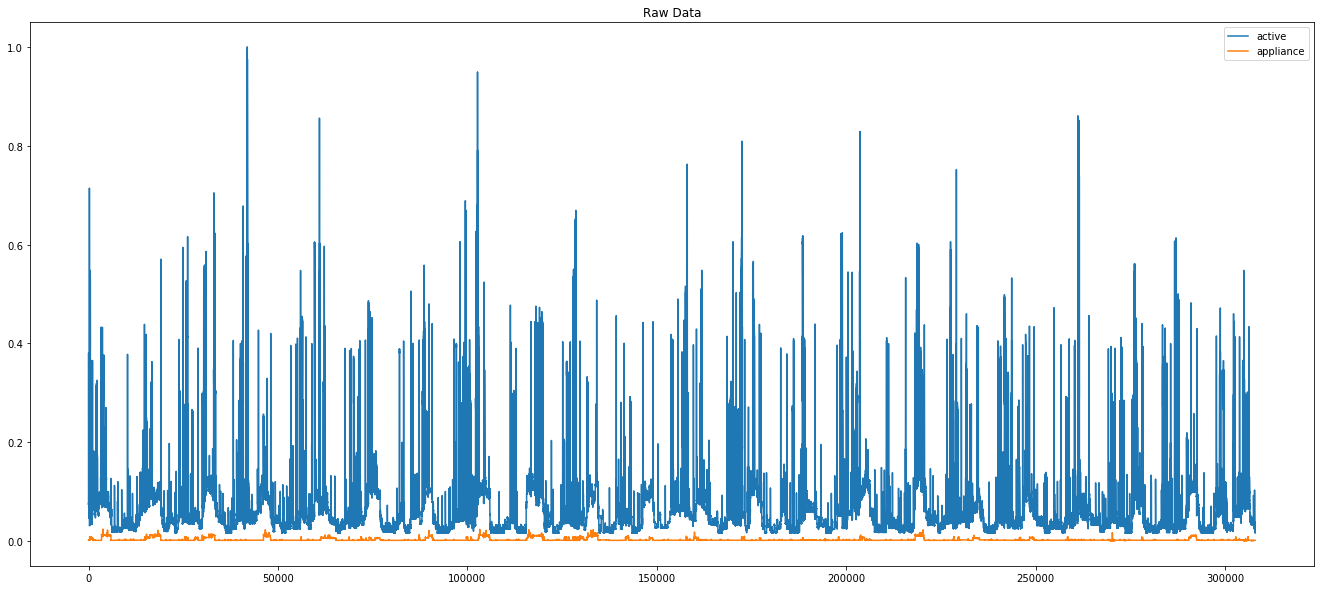

feature selection is done..
model fit is done..
min     0.437441
max     0.076617
diff    0.059108
q2      0.052539
q0      0.049439
std     0.040925
q1      0.029665
f5      0.018262
a9      0.017082
f0      0.016655
mean    0.016429
a0      0.013415
a8      0.012876
a1      0.012354
f1      0.012134
f9      0.012127
a2      0.011510
a7      0.011398
a3      0.010814
a6      0.010536
a4      0.010467
f7      0.010047
f2      0.009941
f3      0.009934
f8      0.009801
f4      0.009780
f6      0.009662
a5      0.009043
dtype: float64


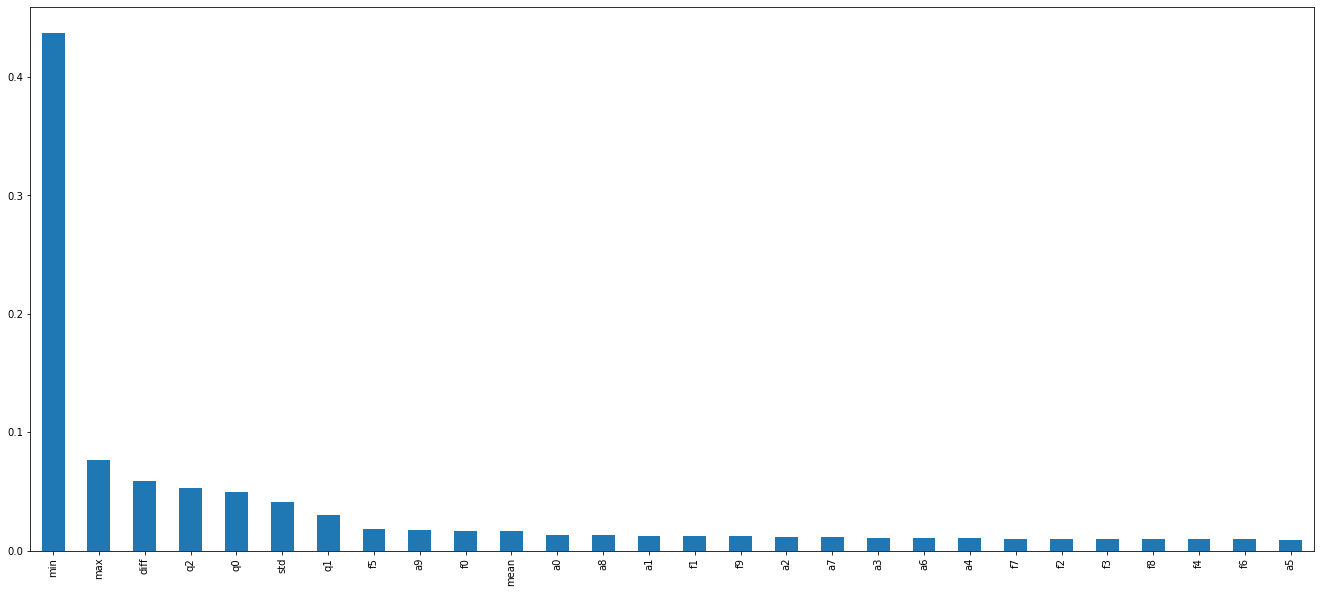

train on chunk is done..
elapsed time (secs) = 922.2448191642761
New sensible chunk: 66963
feature selection is done..
New sensible chunk: 350263
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.1352105710852982
============ Mean absolute error(in Watts): 5.9410708781824155
============ Recall: 0.999908912656826
============ Precision: 0.9998969287154201
============ Accuracy: 0.9998058601474025
============ F1 Score: 0.9999029206502158
********************
[DRF-kettle]
********************


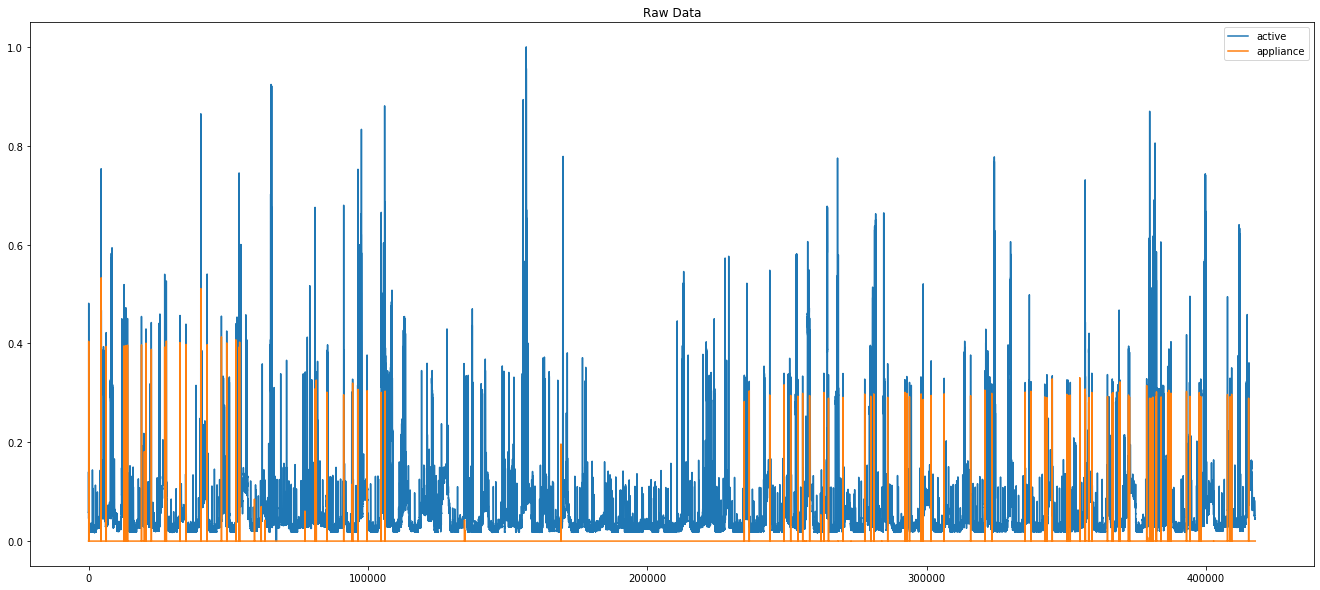

feature selection is done..
model fit is done..
a9      0.154579
diff    0.123114
max     0.099963
q0      0.098054
a8      0.068102
min     0.063929
std     0.036343
q2      0.032304
q1      0.029159
a7      0.028579
f5      0.022031
f0      0.022011
a0      0.021887
a2      0.019785
a1      0.017623
a3      0.017223
mean    0.015899
f9      0.015389
f1      0.015282
a6      0.014312
f7      0.011330
a5      0.011327
a4      0.011294
f3      0.011116
f8      0.010286
f4      0.010052
f6      0.009543
f2      0.009484
dtype: float64


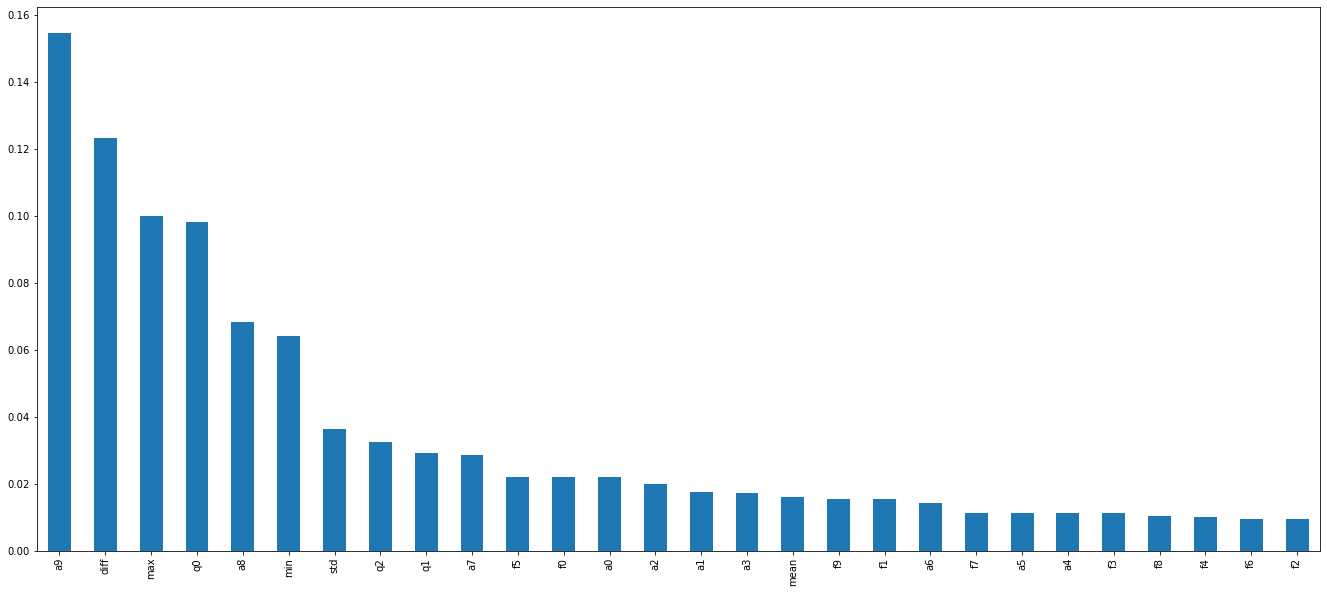

train on chunk is done..
elapsed time (secs) = 1700.1772339344025
New sensible chunk: 66963
feature selection is done..
New sensible chunk: 350263
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.006095189944148064
============ Mean absolute error(in Watts): 3.1981821363206544
============ Recall: 0.18146150073565473
============ Precision: 0.24462809917355371
============ Accuracy: 0.9595685781053388
============ F1 Score: 0.20836266366324085
********************
[DRF-boiler]
********************


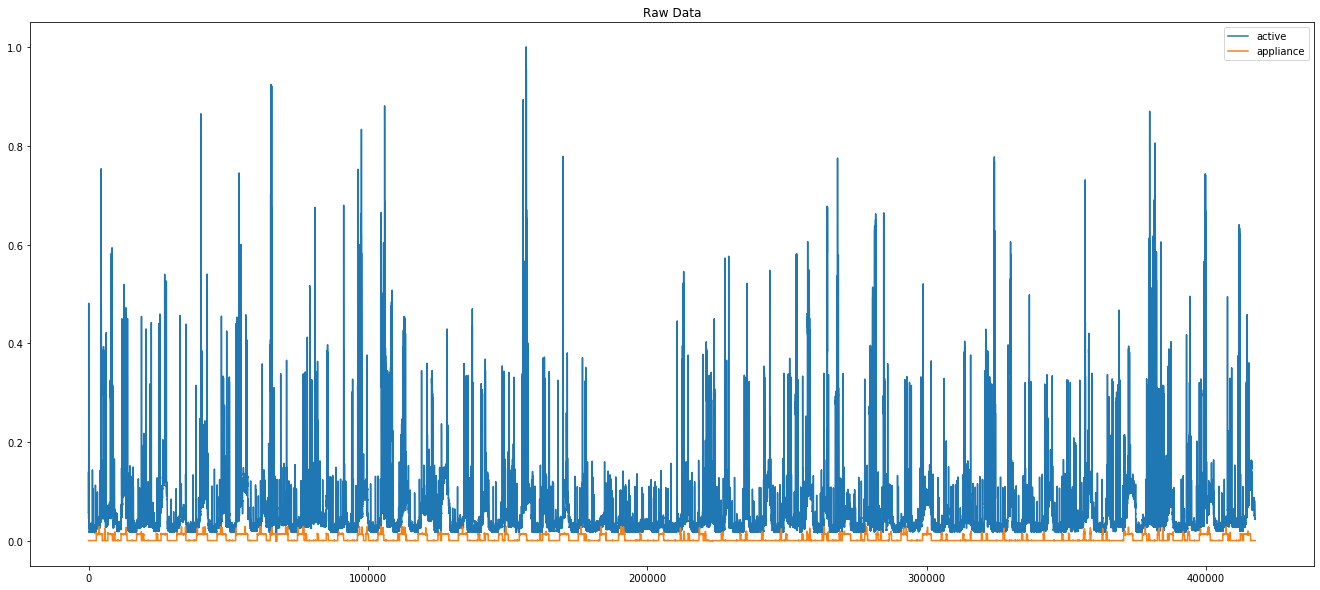

feature selection is done..
model fit is done..
min     0.398436
max     0.069126
diff    0.054270
std     0.049758
q2      0.039180
q0      0.038877
q1      0.026258
f5      0.023853
a9      0.020974
f0      0.017545
mean    0.017099
f1      0.016940
a0      0.016835
f9      0.016802
a8      0.015480
a1      0.015159
f2      0.014875
f8      0.014866
f7      0.014283
f4      0.014274
f3      0.014251
f6      0.014218
a7      0.013768
a2      0.013657
a3      0.013086
a6      0.013060
a4      0.012833
a5      0.010238
dtype: float64


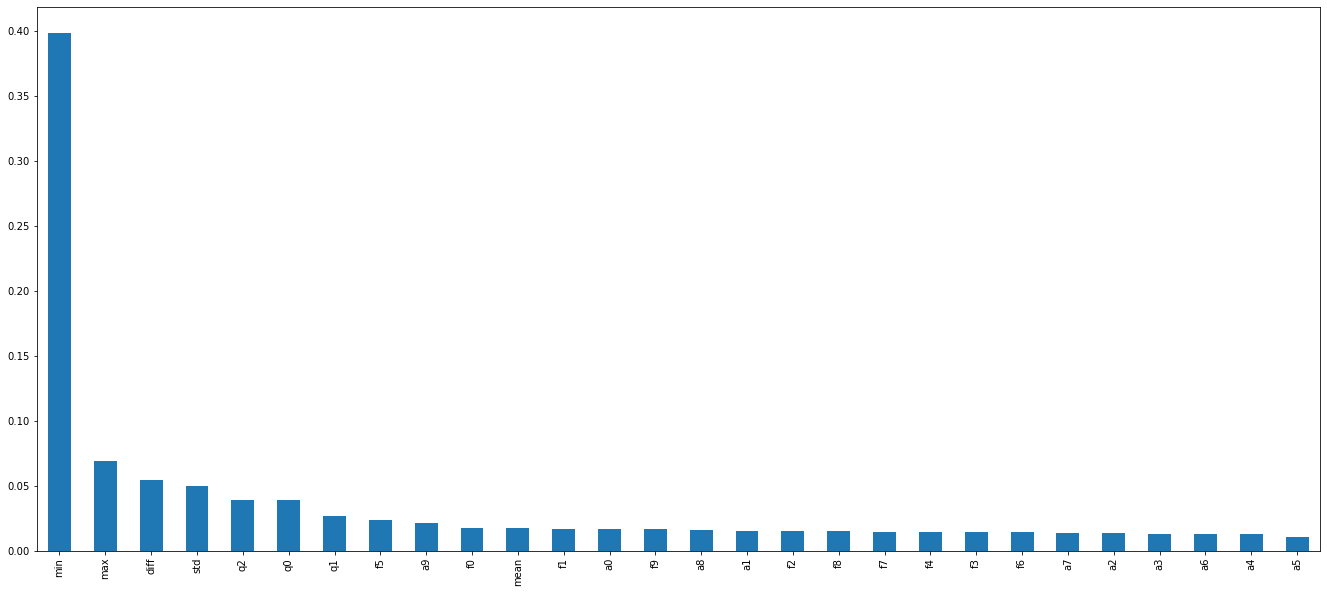

train on chunk is done..
elapsed time (secs) = 1137.535753250122
New sensible chunk: 66963
feature selection is done..
New sensible chunk: 350263
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.021835004413369597
============ Mean absolute error(in Watts): 6.894041763674674
============ Recall: 0.9442703890201645
============ Precision: 0.9850601688508065
============ Accuracy: 0.9777602013302175
============ F1 Score: 0.9642340915135467
********************
[DRF-freezer]
********************


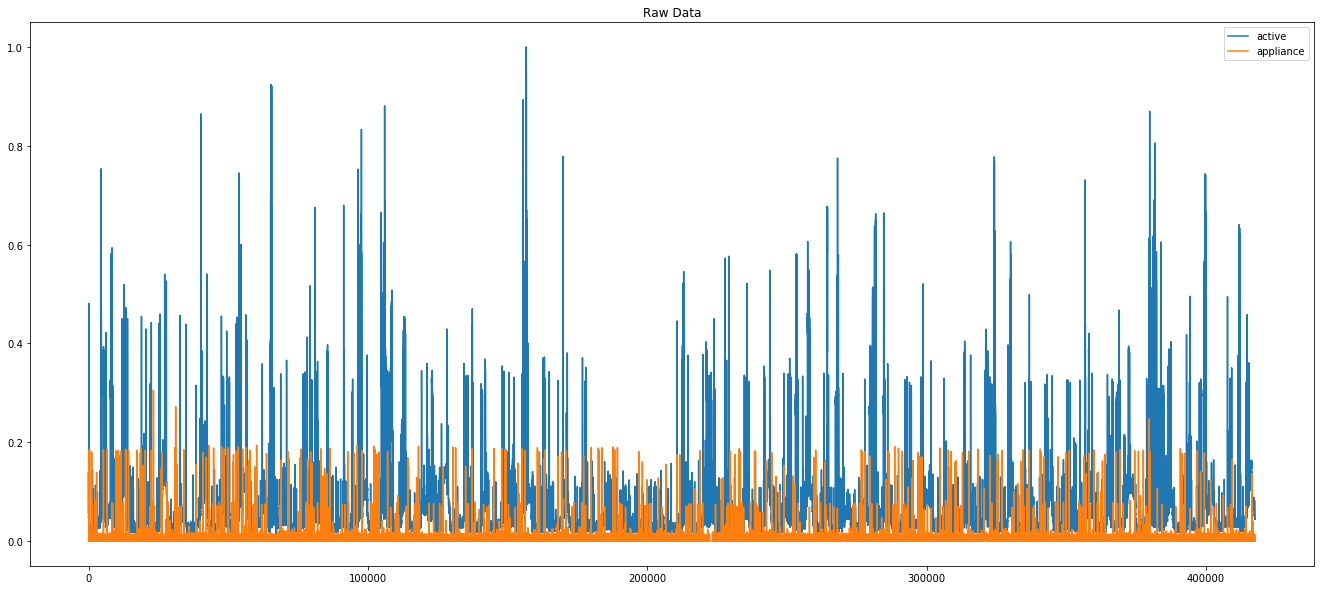

feature selection is done..
model fit is done..
a9      0.237299
diff    0.054877
std     0.054455
min     0.048484
max     0.045565
a8      0.040740
f0      0.038957
q2      0.034793
mean    0.034528
q0      0.033187
f5      0.031444
f2      0.024942
f9      0.024801
f1      0.024727
f8      0.024112
f6      0.022266
f4      0.021993
f7      0.021863
f3      0.021604
a0      0.021034
q1      0.020543
a1      0.020056
a7      0.017357
a2      0.016942
a6      0.016242
a3      0.016033
a4      0.015653
a5      0.015504
dtype: float64


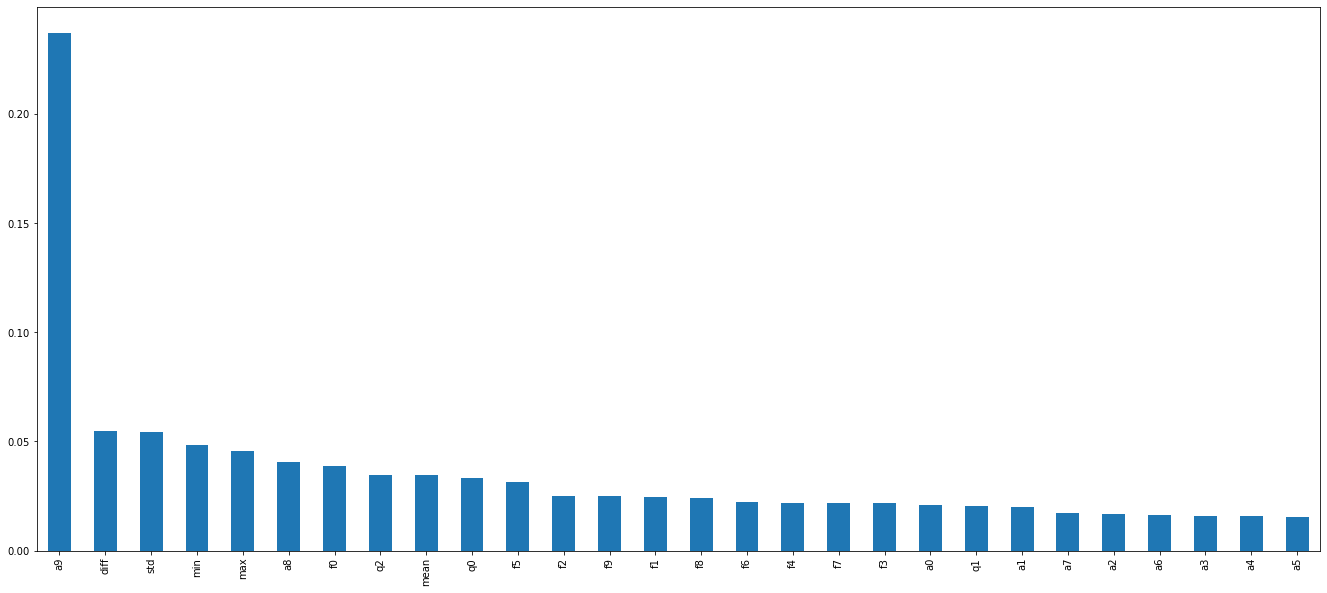

train on chunk is done..
elapsed time (secs) = 1081.9116170406342
New sensible chunk: 66963
feature selection is done..
New sensible chunk: 350263
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.022768008107549337
============ Mean absolute error(in Watts): 7.066049411437215
============ Recall: 0.961117628092994
============ Precision: 0.7241691218276736
============ Accuracy: 0.8585103960692672
============ F1 Score: 0.8259860925649167
********************
[DRF-washing machine]
********************


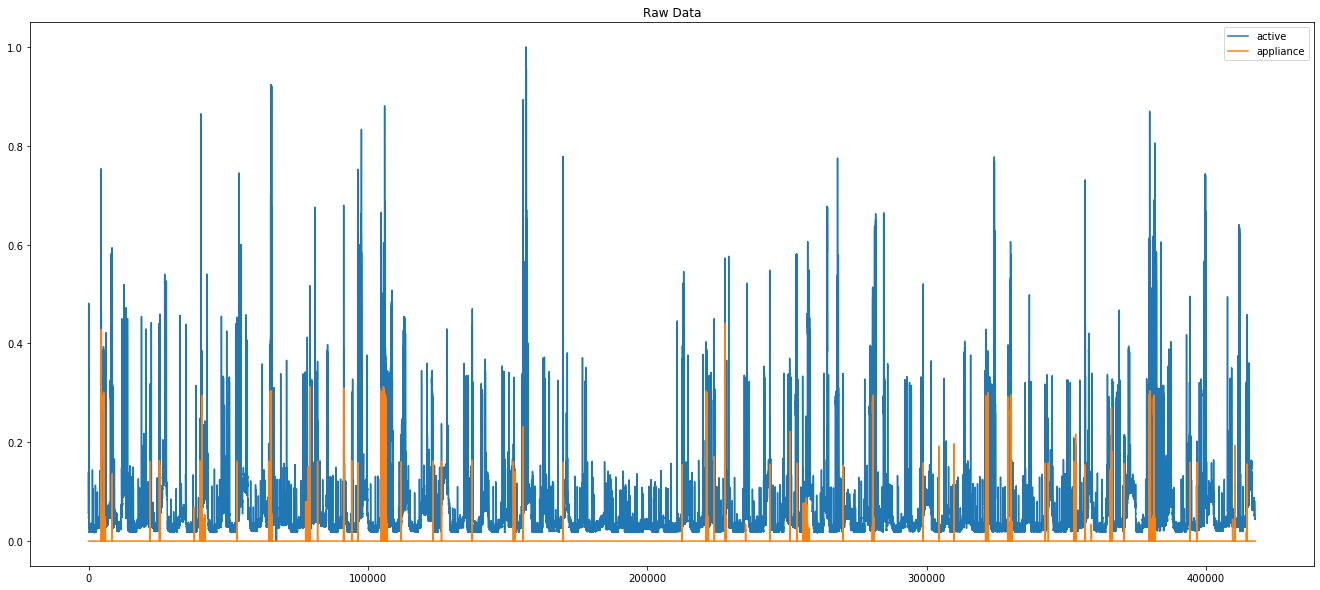

feature selection is done..
model fit is done..
diff    0.317287
mean    0.127425
f0      0.090629
min     0.074808
std     0.071061
max     0.057414
q0      0.033038
q1      0.029638
a9      0.028740
q2      0.024228
a8      0.021434
a7      0.011179
a2      0.009674
f5      0.009043
a0      0.008806
a6      0.008639
a4      0.007877
a3      0.007651
a1      0.007557
a5      0.007015
f9      0.006655
f1      0.006289
f2      0.005992
f8      0.005779
f7      0.005592
f3      0.005572
f4      0.005513
f6      0.005467
dtype: float64


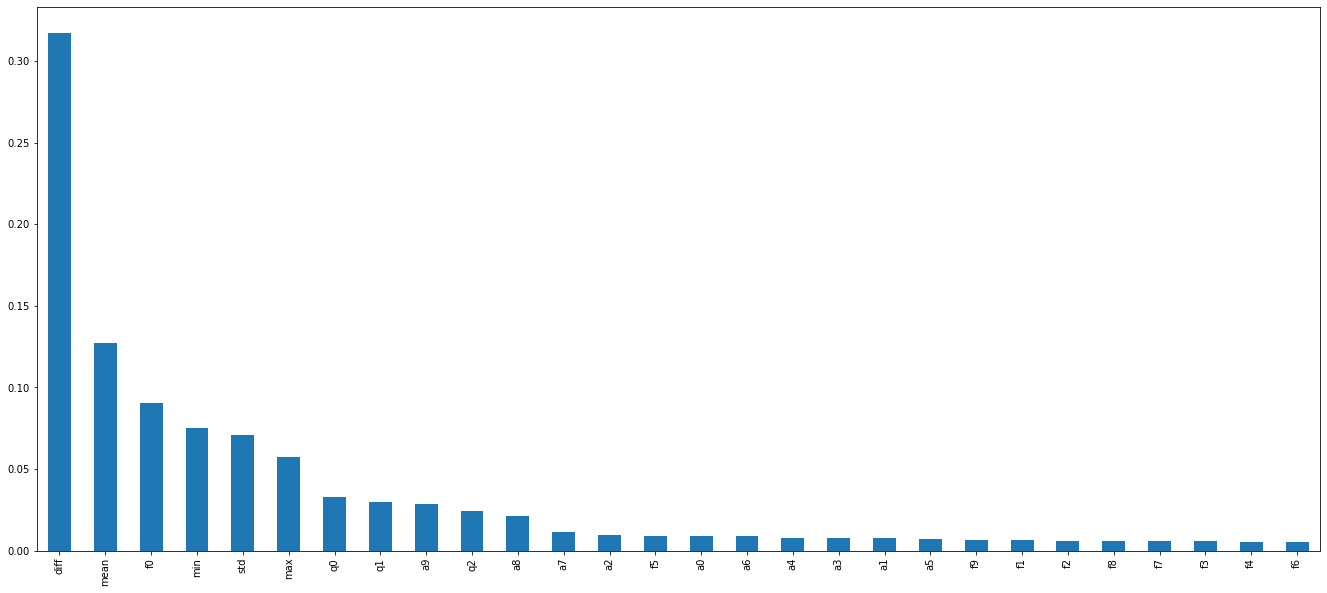

train on chunk is done..
elapsed time (secs) = 1235.8259496688843
New sensible chunk: 66963
feature selection is done..
New sensible chunk: 350263
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.0134956220910727
============ Mean absolute error(in Watts): 3.386639956886183
============ Recall: 0.5339334568881828
============ Precision: 0.5466949803460895
============ Accuracy: 0.950638144885853
============ F1 Score: 0.5402388659448599


In [4]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)

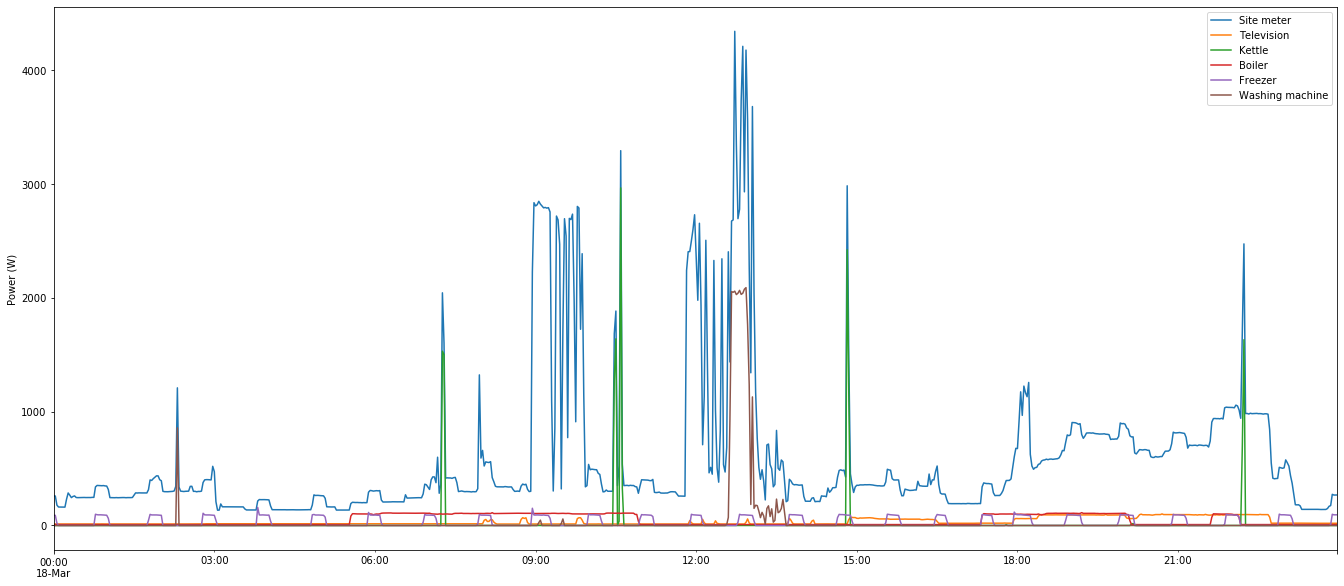

In [14]:
dataset.set_window(start='2013-03-18', end='2013-03-19')
train_elec.plot()
plt.show()